# Capstone Technical Report

# Executive Summary

Traditionally, retail rental prices were determined based on location as well as available floor area. Typically, a retail business owner would focus on choosing the location since floor space requirement is usually fixed by the type of business. Intuitively, the price of a location is determined by its "ability" to capture potential customers. The more exposure a location has to customers, the more expensive a location is. However, except for large corporations, which can afford to conduct exhaustive research, small and medium sized business owners usually were not able to quantify this "ability" of a location.

This project attempts to use data from non-traditional real-estate sources to complement traditional ones to provide business owners a more accurate and robust method of predicting retail rental prices.

Retail rental information such as addresses and floor space available units were scraped from a listing website for over 500 retail units. Two main sources of complementary data were obtained: (1) New York Yellow Cab passenger dropoff data, downloaded from New York Taxi and Limousine Commission, and; (2) Social media data from Yelp business reviews, scraped from Yelp.com. All data was restricted to New York City only.

Results from project indicates improvement over traditional data. Best performing model used was Random Forest Regressor. Cross-validated r-squared score of best model increased by about 36.8% with minimal increase in standard deviation (r2 = 0.38, SD = 0.14 to r2 = 0.52, SD = 0.15). Project is also able to quantify the expected additional cost of locations with higher taxi passenger dropoffs and more Yelp users reviews. 13 continuous variable features were used, in conjunction with physical location data (zipcodes) for modeling.

In the best performing model, top two most important features are (1) Number of taxi passenger dropoff between 1200 to 1800 hrs, and; (2) Floor space of unit. Least important features were (1) Standard deviation of Yelp "$" ratings of 10 nearest businesses, and; (2) Standard deviation of Yelp user ratings (0 to 5 stars) of 10 nearest businesses.

Potential future work can be separated into its three data sources: (1) Include historical transaction prices of nearby retail locations; (2) Include green taxi and Uber passenger dropoff data, and; (3) Normalizing Yelp user review counts by time, restricting to number of reviews for past one year and including other sources of user reviews such as Google, for reliability triangulation.

# Hypothesis

Higher taxi dropoff counts and Yelp user review metrics (Number of reviews, average review ratings, "$" rating and user review corpus sentiments) correlates with higher retail rental prices.

# Technical Analyses

In [1]:
import pandas as pd
import numpy as np

import random

import pickle

from sklearn.feature_extraction.text import CountVectorizer

import geopandas as gpd

import folium
from IPython.display import HTML

from shapely.geometry import Polygon, Point, MultiPolygon

import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

from IPython.core.display import HTML

%matplotlib inline

In [85]:
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedShuffleSplit, KFold, GridSearchCV

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.feature_selection import SelectPercentile, RFECV, RFE

In [66]:
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline

from sklearn.metrics import mean_squared_error, r2_score

## Data Wrangling

### Rental data:

- Retail rental data, webscraped from www.cityfeet.com (locations in NYC only)

In [4]:
with open ('/Users/peidacai/Desktop/rent_in_nyc_only.pkl') as f:
    rent = pickle.load(f)
    
rent.head(2)

Full_Street_address  SF_avail  Price_per_sf_per_year  \
0         327 W 57th St, New York, NY 10019      3840                 118.75   
1  118 West 14th Street, New York, NY 10011      4200                 140.00   

                                           Prop_desc   Latitude  Longitude  \
0  ("Amazing Location! Perfect for Restaurant or ...  40.767498 -73.984111   
1  ('Prime retail at the base of a luxury residen...  40.737628 -73.997937   

       City  Zipcode                   Position             block_id  
0  New York    10019  [-73.9841113, 40.7674983]  15000US360610139007  
1  New York    10011  [-73.9979368, 40.7376285]  15000US360610071001

In [5]:
rent.shape

(554, 10)

### Taxi data:

- 12 months of taxi data was downloaded from NYC Taxi and Limousine Commission (TLC). However, due to the size of the file, only 1% of this set was used

In [6]:
with open('/Users/peidacai/Desktop/taxi_dropoff_block_df.pkl') as f:
    taxi = pickle.load(f)

taxi.head(2)

tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  trip_distance  \
0  2015-07-01 00:00:20   2015-07-01 00:07:57                1           2.10   
1  2015-07-01 00:00:42   2015-07-01 00:08:27                2           1.18   

   pickup_longitude  pickup_latitude  RatecodeID  dropoff_longitude  \
0        -73.983780        40.755219           1         -73.987389   
1        -74.003471        40.725307           1         -74.004333   

   dropoff_latitude  payment_type         ...           trip_month  \
0         40.733372             1         ...                    7   
1         40.737984             1         ...                    7   

   day_of_week  pickup_hour  dropoff_hour  trip_duration    Avg_spd  \
0            2            0             0            7.0  18.000000   
1            2            0             0            7.0  10.114286   

                     dropoff_point  zipcode                    dropoff_Point  \
0  [-73.9873886108, 40.7333717346]    10003  [-73.9873886108, 40.7333717346]   
1  [-74.0043334961, 40.7379837036]    10014  [-74.0043334961, 40.7379837036]   

         dropoff_block  
0  15000US360610042001  
1  15000US360610077003  

[2 rows x 27 columns]

In [7]:
taxi.shape

(1316850, 27)

### Approach to obtaining social media (Yelp business reviews) data:

- For each rental location in the first dataframe, data was scraped from Yelp.com for the respective top 10 nearest businesses.
- For each of these neighboring businesses, the first 20 user reviews were obtained for sentiment analyses of the geographical location.
- Hence, an average rental location has a list of 10 nearest businesses with 200 user reviews of these 10 businesses.
- For some less popular areas, data was not able for all 10 nearest businesses (less than 10 businesses in the area) or less than 20 user reviews exists for some busineses. All Yelp metrics were average, to avoid this issue.

In [8]:
with open('/Users/peidacai/Desktop/yelp_data_cleaned.pkl') as f:
    yelp = pickle.load(f)

yelp.head(2)

Business_name                   Street_address  Cost  Rating  \
0  Sfilatino Italian Gourmet  342 W 57th StNew York, NY 10019     2     4.0   
1     ABA Turkish Restaurant  325 W 57th StNew York, NY 10019     2     4.0   

   Review Count                                        Web_address  \
0           121  https://www.yelp.com/biz/sfilatino-italian-gou...   
1           275  https://www.yelp.com/biz/aba-turkish-restauran...   

                      Rental_address  cate_american  cate_asian  \
0  327 W 57th St, New York, NY 10019              0           0   
1  327 W 57th St, New York, NY 10019              0           0   

   cate_bakeries    ...      cate_spanish  cate_sushi  cate_tapas  cate_tea  \
0              0    ...                 0           0           0         0   
1              0    ...                 0           0           0         0   

   cate_thai  cate_traditional  cate_vegan  cate_vegetarian  cate_venues  \
0          0                 0           0                0            0   
1          0                 0           0                0            0   

   cate_wine  
0          0  
1          0  

[2 rows x 57 columns]

In [9]:
yelp.shape

(5510, 57)

### Neighboring businesses user reviews

In [10]:
with open('/Users/peidacai/Desktop/yelp_reviews2.pkl') as f:
    reviews = pickle.load(f)

reviews.head(2)

Reviewer_location                                        Review_text  \
0     Manhattan, NY  Absolutely love this place!! I always order a ...   
1  White Plains, NY  Good Pizza. Delivery on time. Will try again. ...   

                                         biz_webpage  
0  https://www.yelp.com/biz/giovanis-big-pizza-br...  
1  https://www.yelp.com/biz/giovanis-big-pizza-br...

In [11]:
reviews.shape

(30005, 3)

### Combined data: Rent, taxi, yelp

In [12]:
with open('/Users/peidacai/Desktop/rent_yelp_taxi_df.pkl') as f:
    rent_yelp_taxi = pickle.load(f)

rent_yelp_taxi.head(2)

Full_Street_address  SF_avail  Price_per_sf_per_year  \
0         327 W 57th St, New York, NY 10019      3840                 118.75   
1  118 West 14th Street, New York, NY 10011      4200                 140.00   

                                           Prop_desc   Latitude  Longitude  \
0  ("Amazing Location! Perfect for Restaurant or ...  40.767498 -73.984111   
1  ('Prime retail at the base of a luxury residen...  40.737628 -73.997937   

       City  Zipcode                   Position             block_id  \
0  New York    10019  [-73.9841113, 40.7674983]  15000US360610139007   
1  New York    10011  [-73.9979368, 40.7376285]  15000US360610071001   

           ...           Review_min  Sentiment_mean  Sentiment_std  \
0          ...                   41        0.211583       0.060270   
1          ...                   32        0.200312       0.063121   

   Sentiment_max  Sentiment_min  dropoff_count  dropoff_hr_0600_1200  \
0       0.317372       0.100961           1681                 369.0   
1       0.292630       0.123966            794                 157.0   

   dropoff_hr_1200_1800  dropoff_hr_1800_2359  dropoff_hr_2359_0600  
0                 549.0                 564.0                 199.0  
1                 269.0                 258.0                 110.0  

[2 rows x 31 columns]

In [13]:
rent_yelp_taxi.columns

Index([u'Full_Street_address', u'SF_avail', u'Price_per_sf_per_year',
       u'Prop_desc', u'Latitude', u'Longitude', u'City', u'Zipcode',
       u'Position', u'block_id', u'Cost_mean', u'Cost_std', u'Cost_max',
       u'Cost_min', u'Rate_mean', u'Rate_std', u'Rate_max', u'Rate_min',
       u'Review_mean', u'Review_std', u'Review_max', u'Review_min',
       u'Sentiment_mean', u'Sentiment_std', u'Sentiment_max', u'Sentiment_min',
       u'dropoff_count', u'dropoff_hr_0600_1200', u'dropoff_hr_1200_1800',
       u'dropoff_hr_1800_2359', u'dropoff_hr_2359_0600'],
      dtype='object')

In [14]:
rent_yelp_taxi.shape

(542, 31)

## Outlier Identification

### Rental Prices outlier

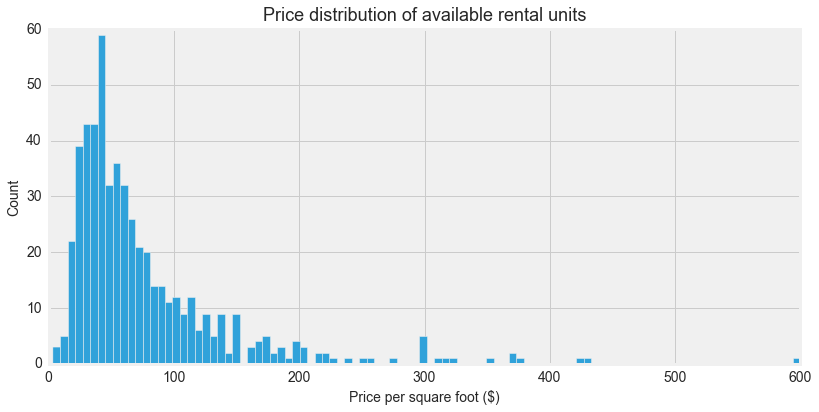

In [15]:
# Price distribution of available rental units

ax = rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000]['Price_per_sf_per_year'].hist(figsize = (12, 6), bins = 100)
ax.tick_params(axis='both', labelsize = 14)
ax.set_title('Price distribution of available rental units', y = 1.01, fontsize = 18)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel('Price per square foot ($)', fontsize = 14)
plt.savefig('Price_distribution_rent_units.png');

In [16]:
rent_yelp_taxi['Price_per_sf_per_year'].describe()

count    542.000000
mean      76.420535
std       67.559812
min        3.340000
25%       36.000000
50%       55.500000
75%       90.000000
max      600.000000
Name: Price_per_sf_per_year, dtype: float64

In [17]:
rent_yelp_taxi[rent_yelp_taxi['Price_per_sf_per_year'] > 500]

Full_Street_address  SF_avail  Price_per_sf_per_year  \
276  147 Spring Street, New York, NY 10012      1800                  600.0   

                                             Prop_desc   Latitude  Longitude  \
276  ('Located between Wooster and West Broadway.  ...  40.724437 -74.001269   

         City  Zipcode                   Position             block_id  \
276  New York    10012  [-74.0012695, 40.7244374]  15000US360610049001   

             ...           Review_min  Sentiment_mean  Sentiment_std  \
276          ...                   22        0.257579       0.056347   

     Sentiment_max  Sentiment_min  dropoff_count  dropoff_hr_0600_1200  \
276       0.373362       0.185547           4878                1312.0   

     dropoff_hr_1200_1800  dropoff_hr_1800_2359  dropoff_hr_2359_0600  
276                2222.0                1143.0                 201.0  

[1 rows x 31 columns]

#### Comments:

Average rental prices in NYC should be in the region of about \$800 per square foot per year, with the highest prices in the region of about \$4,000. The price distribution is very much lower than the values reported in the [media](https://www.rebny.com/content/rebny/en/newsroom/research/REBNYRetailReport/Spring_2016_Manhattan_Retail_Report.html). Average prices on 34th street between 5th and 7th avenue is about \$890.

Prime units such as these are usually not listed publicly on the market, they are usually marketed exclusively by high end property management companies.

Nevertheless, while not ideal, the project can continue with the current set of rental units, including the outlying $600 unit to allow for some representation of super prime units in the data set.

### Floor space outliers

In [18]:
rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000]['SF_avail'].describe()

count      542.000000
mean      2739.662362
std       2825.287836
min        225.000000
25%       1000.000000
50%       1747.000000
75%       3200.000000
max      17785.000000
Name: SF_avail, dtype: float64

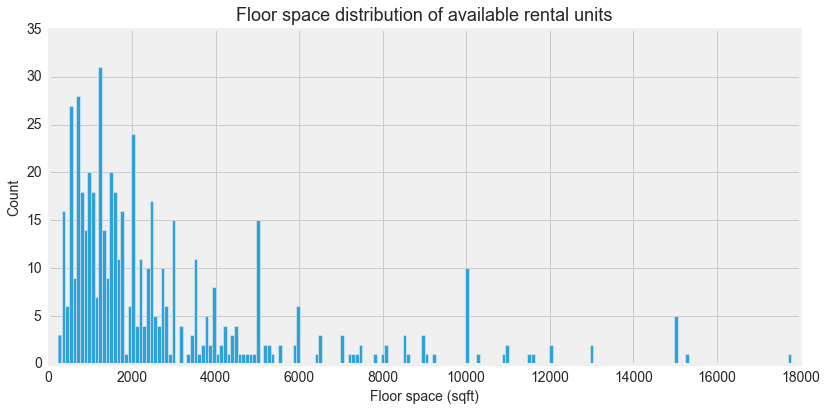

In [19]:
# Floor space distribution of available rental units (< 20,000)

ax = rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000]['SF_avail'].hist(figsize = (12, 6), bins = 200)
ax.tick_params(axis='both', labelsize = 14)
ax.set_title('Floor space distribution of available rental units', y = 1.01, fontsize = 18)
ax.set_ylabel('Count', fontsize = 14)
ax.set_xlabel('Floor space (sqft)', fontsize = 14)
plt.savefig('Floor_space_distribution_rent_units.png');

#### Comments:

There were 10 listings which were over 20,000 sqft in the dataset in terms of available floor space. Most of these were listings for entire projects, with floor space and psf data entered as the largest and lowest respectively. The decision was to drop these entries as such potential market for extraordinarily large spaces is very small and summarized information for entire projects is unreliable.

Sidenote: From the histogram above, it also seem to indicate that listings tend to round floor spaces to whole numbers, as indicated by the spikes in round number floor spaces such as 5,000, 10,000 and 15,000.

In [20]:
price_size = rent_yelp_taxi[rent_yelp_taxi['SF_avail'] < 20000][['Price_per_sf_per_year', 'SF_avail']]

scale = RobustScaler()

price_size = scale.fit_transform(price_size)
price_size = pd.DataFrame(price_size, columns = ['Price_per_sf_per_year', 'SF_avail'])

In [21]:
price_size.describe()

Price_per_sf_per_year    SF_avail
count             542.000000  542.000000
mean                0.387417    0.451210
std                 1.251108    1.284222
min                -0.965926   -0.691818
25%                -0.361111   -0.339545
50%                 0.000000    0.000000
75%                 0.638889    0.660455
max                10.083333    7.290000

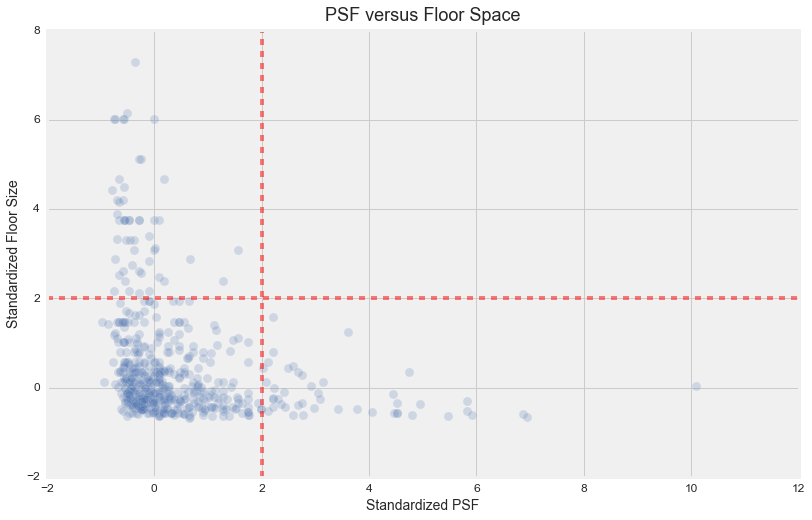

In [22]:
ax = price_size.plot.scatter('Price_per_sf_per_year', 'SF_avail', figsize = (12,8), s = 80, alpha  = 0.2)

ax.axvline(x = 2,  linestyle='--', color = 'r', alpha = 0.5)
ax.axhline(y = 2,  linestyle='--', color = 'r', alpha = 0.5)

ax.tick_params(axis = 'both', labelsize = 12)
ax.set_ylabel('Standardized Floor Size', fontsize = 14)
ax.set_xlabel('Standardized PSF', fontsize = 14)
ax.set_title('PSF versus Floor Space', y = 1.01, fontsize = 18)
plt.savefig('Scatter_psf_floor_space.png');

In [23]:
# Correlation of PSF witih floor space
price_size.corr()

Price_per_sf_per_year  SF_avail
Price_per_sf_per_year               1.000000 -0.264614
SF_avail                           -0.264614  1.000000

#### Comments:

All large units (> 2 standardized unit) has low prices (< 2) and all expensive units (> 2) have small sizes (< 2).

## Taxi EDA - Dropoff counts by the hour

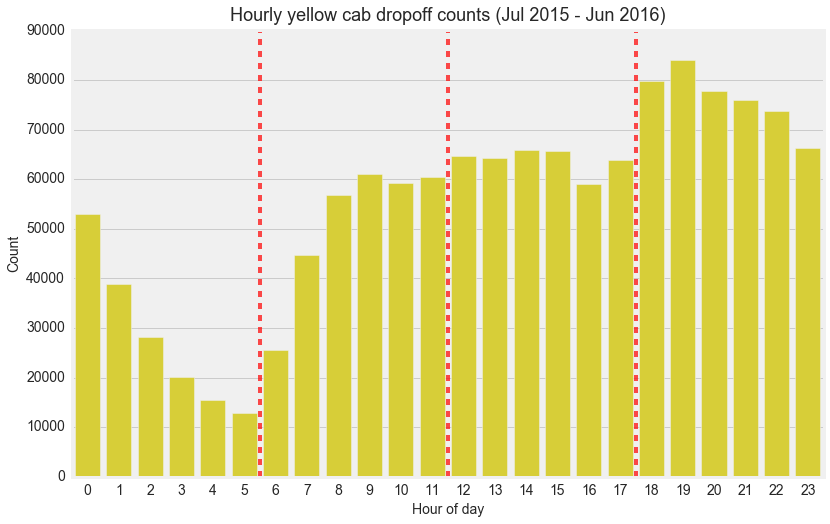

In [24]:
# Dropoff distribution across hour of day

plt.figure(figsize=(12,8))
    ax = sns.countplot(x = 'dropoff_hour', data = taxi, color='#F2E51D')

# Potential bins for modelling later
ax.axvline(x = 5.5,  linestyle='--', color = 'r', alpha = 0.7)
ax.axvline(x = 11.5,  linestyle='--', color = 'r', alpha = 0.7)
ax.axvline(x = 17.5,  linestyle='--', color = 'r', alpha = 0.7)

ax.set_xlabel('Hour of day', fontsize = 14)
ax.set_ylabel('Count', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_title('Hourly yellow cab dropoff counts (Jul 2015 - Jun 2016)', y = 1.01, fontsize = 18)

plt.savefig('hourly_taxi_dropoff_count_segmented.png');

#### Comments:

Passenger dropoff counts plotted against the dropoff hour of the day showed that the time of the day can be broken down into 4 groups:

- Nightlife group
- Morning rush-hour group
- Tourists/Meeting group
- Evening rush-hour group

Binning into such groups could be useful to isolate rental locations for specific business needs such as restaurants, fashion or gyms.

### Taxi EDA - Dropoff count by city blocks

In [25]:
# Loading in a dataframe of dropoff counts by city blocks
# Created separately

with open('/Users/peidacai/Desktop/taxi_dropoff_count_df.pkl', 'r') as f:
    df2 = pickle.load(f)

In [26]:
df2.sort_values('count', ascending = False).head(2)

dropoff_block  count
3460  15000US360610101001  29987
3457  15000US360610099001  19620

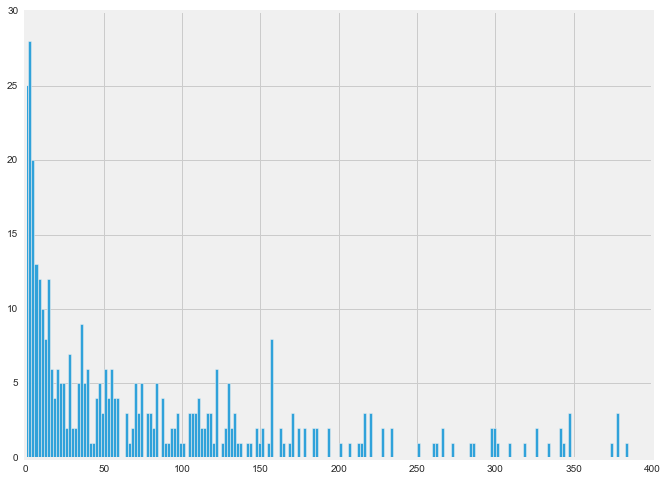

In [27]:
rent_yelp_taxi[rent_yelp_taxi['dropoff_count'] < 400]['dropoff_count'].hist(bins = 200, figsize = (10,8))

In [28]:
rent_yelp_taxi['dropoff_count'].describe()

count      542.000000
mean       675.680812
std       1758.797993
min          0.000000
25%         18.250000
50%         95.500000
75%        472.000000
max      19620.000000
Name: dropoff_count, dtype: float64

In [29]:
# Using folium to create the html file

# Defining path for geojson cityblock overlay for NYC city block boundaries
nyc_block_geo = '/Users/peidacai/Desktop/rdf.json'

# Initializing starting center position and zoom_state
m = folium.Map(location=[40.748660, -73.985741], zoom_start=13)


# Add a geojson layer of the zipcode from geojson file containing NYC zipcode polygons
m.choropleth(geo_path = nyc_block_geo,
             
             #Adding choropleth layer
             data = df2,
             columns = ['dropoff_block', 'count'],
             
             key_on = 'feature.properties.geo_id',
             threshold_scale=[0,500,3000,8000,15000,30000],
             fill_color = 'YlGnBu',
             fill_opacity = 0.6,
             line_opacity = 0.1,
             legend_name = 'Taxi dropoff counts',
             reset = True
              )

# Displaying inline
m


#### Comments:

I wanted to use NYC city block data, however, due to its high granularity nature, it is computationally inefficient. Therefore, this geojson file was chosen instead, as a compromise between cityblock and zipcodes.

Beside the transport hubs such as Penn and Grand Central Stations and the airports, the other highest dropoff places were on the west, near Jacob Javits Convention Center as well as Central Park.

While the taxi dropoff count data is very skewed, there are available units within these locations and I wished to include representation of such high dropoff counts in the model.

One way to work around these is to have separate models for tiered dropoff counts, perhaps a model for high (> 75th percentile) and a model for the rest. However, the main restriction in this project was the lack of data on available rental units. Given enough data, it would be more ideal to have separate models.

## How much is taxi passengers worth to retail business owners?

In [30]:
# Removing outliers

r = rent_yelp_taxi[rent_yelp_taxi['dropoff_count']<= 10000]
r = r[r['Price_per_sf_per_year'] <= 400]

In [31]:
lr = LinearRegression()
lr.fit(r['dropoff_count'].values.reshape(1,-1), r['Price_per_sf_per_year'].values.reshape(1,-1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [32]:
line_coef = np.polyfit(r['dropoff_count'].values,
                       r['Price_per_sf_per_year'].values,
                       1)
line_coef

array([  2.03150034e-02,   6.24798615e+01])

In [33]:
# Coefficient indicated every 100 increase in passenger dropoff, retailers pay $0.02 psf per year more
# 100 since we used only 1% of the entire taxi data
# so 1 unit increase on x-axis is 100 increase in passenger dropoff

# Equation is:
# Coefficient * 1000 passenger dropoff * Average size of retail location
# Returns additional rental to pay for every 100,000 increase in passenger dropoff every year

line_coef[0] *1000 * 2700

54850.509242866363

### Comments:

On average, retail business owners are expected to pay a premium of about \$20.3 per sqft per year more for every 100,000 more passenger dropoff. For a mean floor area of 2,700, this amounts to about \$54,850 increased every year, or about \$0.55 per passenger per year. Can higher taxi dropoff be translated to higher revenue? We will need to marry this analyses with sales data to justify this:

- Conversion rate of taxi dropoff to sales (Revenue per dropoff)
    - Examine relationship between taxi dropoff counts and sales based on existing locations
- COGS
    - Justify that increase in sales from higher passenger dropoff areas is economically viable

In [34]:
polynomial = np.poly1d(line_coef)

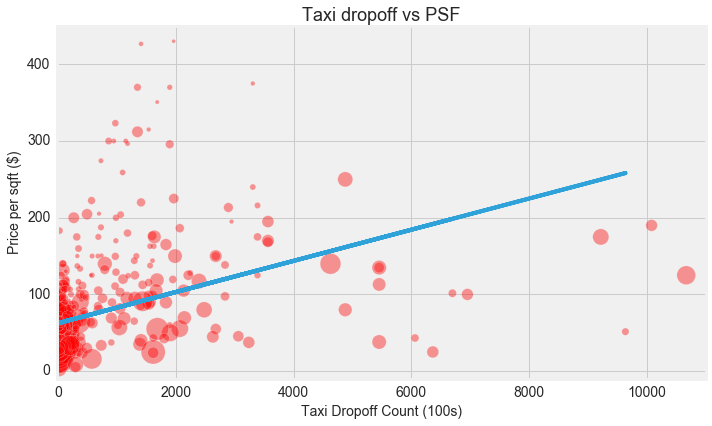

In [35]:
plt.figure(figsize = (10,6))

ax = plt.plot(r['dropoff_count'].values, polynomial(r['dropoff_count'].values))
plt.scatter(rent_yelp_taxi['dropoff_count'], 
            rent_yelp_taxi['Price_per_sf_per_year'], 
            s = (rent_yelp_taxi['SF_avail'] / 20.), c = 'r', 
            alpha = 0.4
           )
plt.ylabel('Price per sqft ($)', fontsize = 14)
plt.xlabel('Taxi Dropoff Count (100s)', fontsize = 14)
plt.ylim(-10,450)
plt.xlim(-10,11000)
plt.title('Taxi dropoff vs PSF', fontsize = 18)
plt.tick_params(axis = 'both', labelsize = 14)
plt.tight_layout()

plt.savefig('Scatter_psf_dropoff.png');


# Yelp Data EDA: Metrics for top 10 nearest businesses

![top_10_businesses](top_10_nearest_businesses_yelp.png)

For each available rental location, social media data is obtained from webscraping Yelp for top 10 nearest businesses for the following metrics:

    1. "$" metric: 
    
        An indication of the type of market in the vincity, i.e. spending power of target segment of businesses in the area

    2. Review ratings: 
    
        While this depends solely on the performance of each individual business, it provides an indication of the acceptability of businesses in the geographical location. It could be a business decision to locate themselves within high performing neighbors or otherwise. A classic big fish in small pond versus small fish in big pond consideration. Another consideration could be locating near complementary businesses, for example a dessert place near high performing restaurant areas to capture after-meal crowds.

    3. Average number of reviews:
    
        This is an indication of the popularity of the geographical location, which is an indication of the potential reach of a geographical location.

## Yelp descriptive statistics

In [36]:
# Descriptive statistics for Yelp "$" metrics
# Descriptive statistics for Yelp user rating (based on 5 stars) metrics
# Descriptive statistics for Yelp number of reviews metrics
# Descriptive statistics for Yelp user review text sentiment analyses metrics

rent_yelp_taxi[['Cost_mean', 'Rate_mean', 'Review_mean', 'Sentiment_mean']].describe()

Cost_mean   Rate_mean  Review_mean  Sentiment_mean
count  542.000000  542.000000   542.000000      542.000000
mean     1.763284    4.131642   192.319188        0.230522
std      0.305069    0.196720   167.480481        0.028009
min      1.000000    3.450000     7.500000        0.076548
25%      1.600000    4.050000    75.775000        0.215683
50%      1.700000    4.150000   136.000000        0.230790
75%      1.900000    4.250000   258.425000        0.248086
max      3.100000    4.600000  1144.600000        0.333194

In [37]:
# Creating a label of 1 for units with psf above mean and 0 otherwise

rent_yelp_taxi['PSF_Above_mean'] = rent_yelp_taxi['Price_per_sf_per_year'].apply(lambda x: 1 if x > rent_yelp_taxi['Price_per_sf_per_year'].mean() else 0)

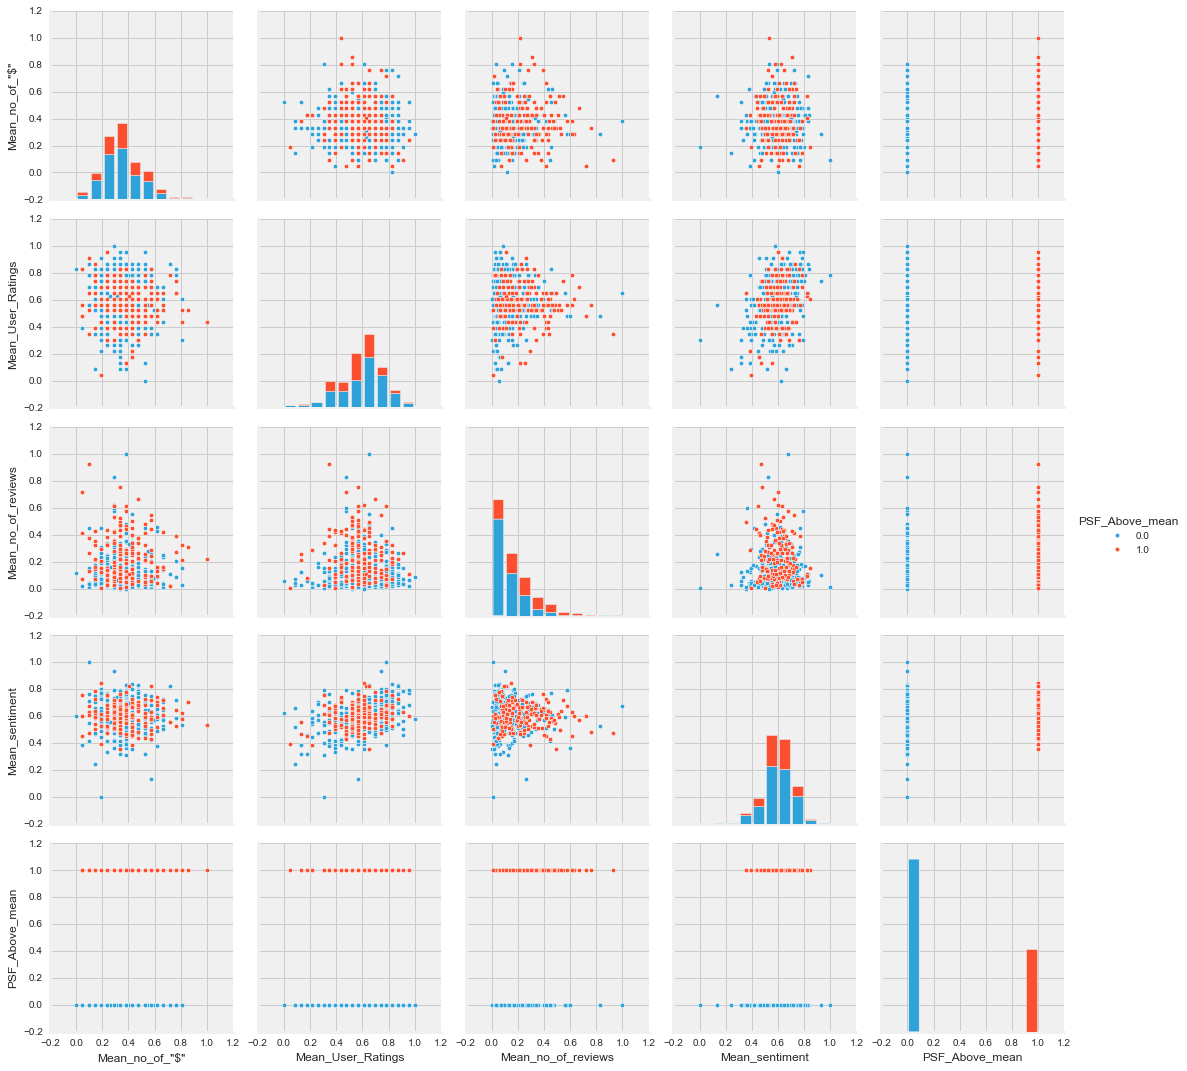

In [38]:
yelp = rent_yelp_taxi[['Cost_mean', 
                       'Rate_mean', 
                       'Review_mean',
                       'Sentiment_mean',
                       'PSF_Above_mean']]

yelp_scale = pd.DataFrame(MinMaxScaler().fit_transform(yelp), columns= ['Mean_no_of_"$"', 
                                                           'Mean_User_Ratings',
                                                           'Mean_no_of_reviews',
                                                           'Mean_sentiment',
                                                           'PSF_Above_mean'])
sns.pairplot(yelp_scale, size = 3, aspect = 1, hue = 'PSF_Above_mean')

#### Comments:

The cost metric (number of '$') and user rating didn't seem to have meaningful predictive abilities. However, it seemed that number of reviews had some meaningful differences.

In [39]:
rent_yelp_taxi.head(1)

Full_Street_address  SF_avail  Price_per_sf_per_year  \
0  327 W 57th St, New York, NY 10019      3840                 118.75   

                                           Prop_desc   Latitude  Longitude  \
0  ("Amazing Location! Perfect for Restaurant or ...  40.767498 -73.984111   

       City  Zipcode                   Position             block_id  \
0  New York    10019  [-73.9841113, 40.7674983]  15000US360610139007   

        ...        Sentiment_mean  Sentiment_std  Sentiment_max  \
0       ...              0.211583        0.06027       0.317372   

   Sentiment_min  dropoff_count  dropoff_hr_0600_1200  dropoff_hr_1200_1800  \
0       0.100961           1681                 369.0                 549.0   

   dropoff_hr_1800_2359  dropoff_hr_2359_0600  PSF_Above_mean  
0                 564.0                 199.0               1  

[1 rows x 32 columns]

In [40]:
# Pivoting yelp data to demonstrate differences in mean between yelp metrics

yelp_piv = pd.pivot_table(yelp_scale, ['Mean_no_of_"$"',
                                       'Mean_User_Ratings',
                                       'Mean_no_of_reviews',
                                       'Mean_sentiment'], 
                          index = 'PSF_Above_mean')

yelp_piv.reset_index(inplace = True, drop = True)
yelp_piv.T

0         1
Mean_User_Ratings   0.604016  0.569068
Mean_no_of_"$"      0.355845  0.379456
Mean_no_of_reviews  0.126388  0.238343
Mean_sentiment      0.599140  0.601644

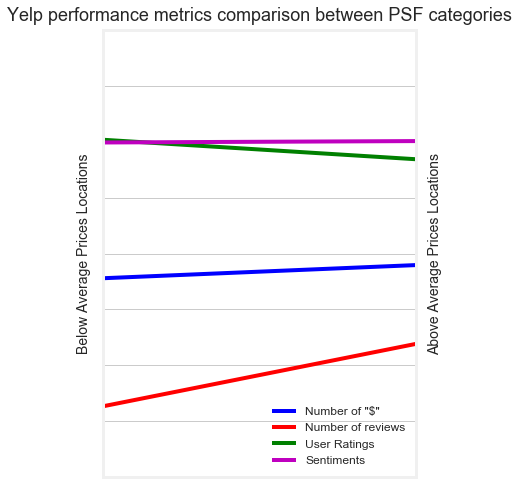

In [117]:
# Plotting yelp performance metrics comparison between PSf categories

x = [0,1]

a = yelp_piv.loc[:, 'Mean_no_of_"$"'].T.values

b = yelp_piv.loc[:, 'Mean_no_of_reviews'].T.values

c = yelp_piv.loc[:, 'Mean_User_Ratings'].T.values

d = yelp_piv.loc[:, 'Mean_sentiment'].T.values

fig, ax = plt.subplots(figsize = (5,8))
ax2 = ax.twinx()
ax.set_axis_bgcolor('white')
ax.grid(which='major',axis = 'x')
ax2.grid(which='major',axis = 'x')

line_a = plt.plot(x, a, 'xb-', label = 'Number of "$"')
line_b = plt.plot(x, b, 'xr-', label = 'Number of reviews')
line_c = plt.plot(x, c, 'xg-', label = 'User Ratings')
line_d = plt.plot(x, d, 'xm-', label = 'Sentiments')

plt.legend(loc='lower right', fontsize = 12)

ax.set_xticklabels([])
ax2.set_yticklabels([])
ax.set_yticklabels([])

ax.set_ylim(0,0.8)
ax2.set_ylim(0,0.8)

ax.set_ylabel('Below Average Prices Locations', fontsize = 14)
ax2.set_ylabel('Above Average Prices Locations', fontsize = 14)


ax.set_title('Yelp performance metrics comparison between PSF categories', y = 1.01, fontsize = 18)
plt.savefig('yelp_performance_compare.png');

#### Comments:

This chart compare yelp metrics between rental units with PSF below or equal to mean (left axis) and units above mean PSF (right axis). Each line represents a yelp performance metric. If there were significant differences between the two PSF categories, we should be seeing lines with high gradients.

The metric which showed highest discriminating ability between the categories was "Number of reviews" (or popularity of a location). Rental locations with prices above the mean PSF had higher number of yelp reviews.

Interestingly, mean user ratings for businesses in "expensive" areas were lower than businesses in "cheaper" areas, evident from the downward sloping green line, though not by much.

Expensive locations didn't correlate with "Number of '$'". Businesses targeting higher-spending power consumers did not neccesarily locate themselves in expensive rental locations.

Finally, sentiment analyses didn't offer much in discriminating ability, may consider to drop this feature when modelling to improve performance.

## How much does 1 more Yelp user review cost retailers?

Since number of Yelp user reviews for businesses in the vicinity seemed to be more correlated, a linear regression is conducted on number of reviews to price to identify the per unit cost of an additional user review.

In [42]:
lr = LinearRegression()
lr.fit(rent_yelp_taxi['Review_mean'].values.reshape(1,-1), rent_yelp_taxi['Price_per_sf_per_year'].values.reshape(1,-1))

line_coef = np.polyfit(rent_yelp_taxi['Review_mean'].values,
                       rent_yelp_taxi['Price_per_sf_per_year'].values,
                       1)
polynomial = np.poly1d(line_coef)

line_coef

array([  0.1525766 ,  47.07712759])

In [43]:
# Cost of 1 more Yelp review for nearby businesses in rental per year
line_coef[0] * 2700

411.9568146737588

In [44]:
# Percentage increase in rental price for every increase in number of Yelp reviews for top 10 nearby businesses
# For average PSF of $76 per year
line_coef[0]/76 *100

0.20075868161489219

### Comments:

On average, every single increase in average number of reviews for top 10 nearest businesses on Yelp results in \$0.15 increase in PSF per year. For an average sized rental location of 2,700 sqft, \$76 PSF per year, 1 increase in Yelp review increases rent by \$411.96 per year; or 0.2 %.

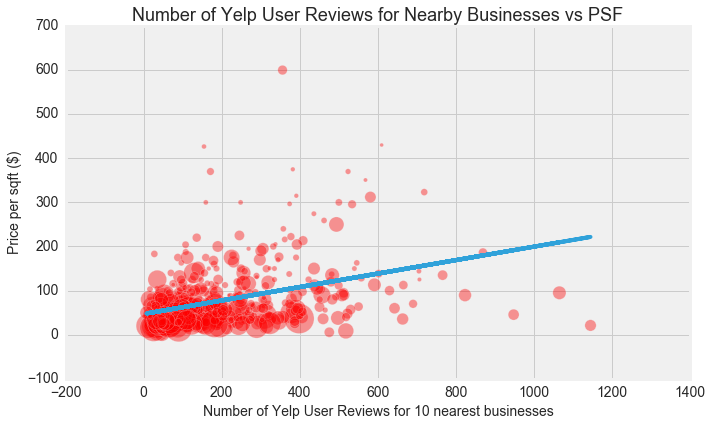

In [45]:
plt.figure(figsize = (10,6))

ax = plt.plot(rent_yelp_taxi['Review_mean'].values, 
              polynomial(rent_yelp_taxi['Review_mean'].values))
plt.scatter(rent_yelp_taxi['Review_mean'], 
            rent_yelp_taxi['Price_per_sf_per_year'], 
            s = (rent_yelp_taxi['SF_avail']/20.), 
            c = 'r', alpha = 0.4)
plt.ylabel('Price per sqft ($)', fontsize = 14)
plt.xlabel('Number of Yelp User Reviews for 10 nearest businesses', fontsize = 14)
#plt.ylim(-10,450)
#plt.xlim(-10,11000)
plt.title('Number of Yelp User Reviews for Nearby Businesses vs PSF', fontsize = 18)
plt.tick_params(axis = 'both', labelsize = 14)
plt.tight_layout()

plt.savefig('Scatter_psf_yelp_review.png');


In [112]:
lr = LinearRegression()
lr.fit(rent_yelp_taxi['Cost_mean'].values.reshape(1,-1), rent_yelp_taxi['Price_per_sf_per_year'].values.reshape(1,-1))

line_coef = np.polyfit(rent_yelp_taxi['Cost_mean'].values,
                       rent_yelp_taxi['Price_per_sf_per_year'].values,
                       1)
polynomial = np.poly1d(line_coef)

line_coef

array([ 14.62534443,  50.63189729])

# Combined analyses

In [46]:
# Applying scaling to both axis
rev_taxi_psf = rent_yelp_taxi[['Review_mean', 
                               'dropoff_count', 
                               'PSF_Above_mean']]

rev_taxi_psf = pd.DataFrame(RobustScaler().fit_transform(rev_taxi_psf), 
                            columns = ['Review_mean', 'dropoff_count', 'PSF_Above_mean'])

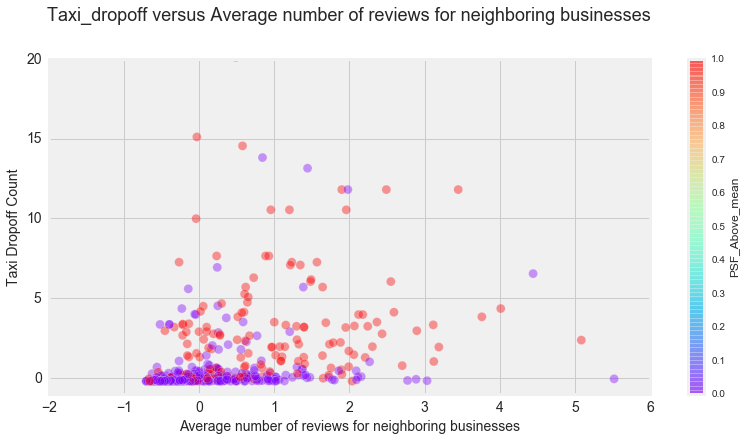

In [47]:
ax = rev_taxi_psf.plot.scatter('Review_mean', 
                               'dropoff_count', 
                               c = 'PSF_Above_mean',
                               cmap = 'rainbow', s = 80, figsize = (12,6), 
                               alpha = 0.4, sharex = False)
ax.set_ylim(-1, 20)

ax.set_xlabel('Average number of reviews for neighboring businesses', 
              fontsize = 14)
ax.set_ylabel('Taxi Dropoff Count', fontsize = 14)
ax.tick_params(axis = 'both', labelsize = 14)

ax.set_title('Taxi_dropoff versus Average number of reviews for neighboring businesses', 
             y = 1.1, fontsize = 18)
plt.savefig('taxi_review_count_psf.png');

#### Comments:

The red plots (locations with above mean prices) tend to have higher taxi dropoff counts. In addition, for all locations with high Yelp review counts, there are more locations with above average prices. This gave more confidence in supporting the hypothesis.

# Examining correlation of all features with prices

In [48]:
# Choosing only continuous features

comb_rent = rent_yelp_taxi[['Price_per_sf_per_year',
                            'SF_avail',
                            'dropoff_count', 
                            'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                            'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600',
                            'Cost_mean', 'Rate_mean',
                            'Review_mean', 'Sentiment_mean']]

In [49]:
# Comparing different types of scalers

ss = StandardScaler()
mm = MinMaxScaler()
rb = RobustScaler()

In [50]:
# Function to return name of ML model and/or scaling method

def return_name(algo):
    return str(algo).split('(')[0]

StandardScaler

++++++++++++++++++++



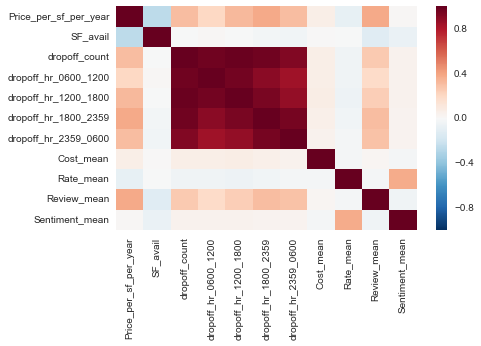

MinMaxScaler

++++++++++++++++++++



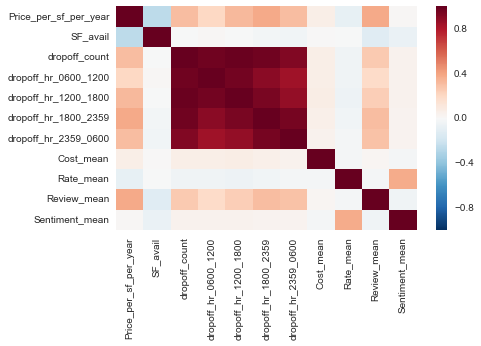

RobustScaler

++++++++++++++++++++



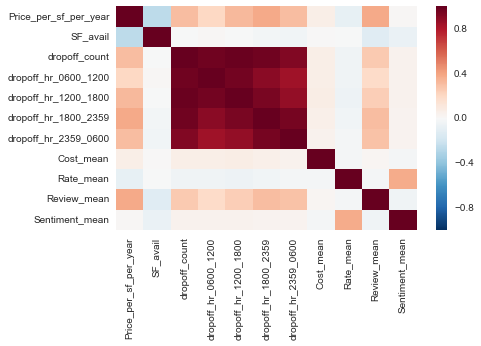

In [51]:
scales = [ss, mm, rb]

for scale in scales:
    scaled_comb_rent = pd.DataFrame(scale.fit_transform(comb_rent), columns = comb_rent.columns)
    print return_name(scale)
    print
    sns.heatmap(scaled_comb_rent.corr())
    print "++++++++++++++++++++"
    print
    plt.show()

#### Comments:

In line with the earlier analyses, higher taxi dropoffs and higher number of yelp reviews in the area did seem to point towards more above average PSF locations.

# Modelling

## Approach

To test the hypothesis, the following approach to modeling will be adopted:

1. Fix random state

2. Specify a fix number of different modeling algorithms with a fixed number of scaling algorithms

3. Compare cross_val_scores of all models (default settings) for the following sets of features:

    a. Floor space available, zipcodes
    b. Floor space available, zipcodes, taxi dropoff count
    c. Floor space available, zipcodes, taxi dropoff count and Yelp review data
    
4. Cross_validation method:

    a. Create dummy variables for zipcodes
    b. Scale continuous features
    c. Concatenate all features
    d. Create ML model
    e. RFE on best model

# Setting up modeling parameters

In [52]:
# Defining a fixed random state
rand = 44

In [53]:
# Regressors models

rfr = RandomForestRegressor(random_state=rand)
etr = ExtraTreesRegressor(random_state=rand)
adar = AdaBoostRegressor(random_state=rand)
gbr = GradientBoostingRegressor(random_state=rand)
linr = LinearRegression()
knnr = KNeighborsRegressor()
svr = SVR()

In [54]:
# List of different regressors models
model_reg = [rfr, etr, adar, gbr, linr, knnr, svr]

In [55]:
stand_scale = StandardScaler()
rob_scale = RobustScaler()
minmax_scale = MinMaxScaler()

In [56]:
# List of different scaling methods
scales = [stand_scale, rob_scale, minmax_scale]

In [57]:
# Function to return name of ML model and/or scaling method

def return_name(algo):
    return str(algo).split('(')[0]

In [134]:
def custom_cross_val(X, y, folds, mod_list, scal_list, no_cont_cols):
    
    #=========Inputs=========================
    # X: the feature matrix in dataframe form
    # continuous features on left and categorical (dummied) on right
    # y: the target
    # folds: the number of folds for cross-validation
    # mod_list: the list of models to try
    # scal_list: the list of scalers to try for continous features
    # no_cont_cols: Number of continuous columns on the left (to be scaled)
    #=========Output========================
    # Dataframe of model, scaler, mean scores, score stdev
    
    # No. of cross-validated folds
    skf = KFold(n_splits=folds, shuffle=True)

    model_list = []
    scale_list = []
    acc_list = []
    std_list = []

    for model in mod_list:

        for scale in scal_list:
            scores = []

            for train_index, test_index in skf.split(X, y):
                
                # Defining X_train, X_test, y_train, y_test manually
                X_train = X[X.index.isin(train_index)]
                X_test = X[X.index.isin(test_index)]
                y_train = y[y.index.isin(train_index)]
                y_test = y[y.index.isin(test_index)]

                # Scaling appropriate columns
                ss_x = scale.fit(X_train.iloc[:,:no_cont_cols])
                ss_y = scale.fit(y_train.values.reshape(-1,1))

                # Scaling train data with train-scalers
                X_train_scale = pd.DataFrame(ss_x.transform(X_train.iloc[:,:no_cont_cols]), columns = X_train.columns[:no_cont_cols], index = X_train.index)
                y_train = ss_y.transform(y_train.values.reshape(-1,1))

                # Scaling test data with train-scalers
                X_test_scale = pd.DataFrame(ss_x.transform(X_test.iloc[:,:no_cont_cols]), columns = X_test.columns[:no_cont_cols], index = X_test.index)
                # No need to transform y_test since it is the "ground truth"

                # Combining with unscaled columns
                X_train = pd.concat([X_train_scale, X_train.iloc[:,no_cont_cols:]], axis = 1)
                X_test = pd.concat([X_test_scale, X_test.iloc[:,no_cont_cols:]], axis = 1)

                # Fitting the model with training data
                model.fit(X_train, y_train.reshape(-1,1))

                # Predicting X_test
                y_pred = model.predict(X_test)

                #y_true_inv = ss_y.inverse_transform(y_test_scale)
                y_pred_inv = ss_y.inverse_transform(y_pred)

                scores.append(mean_squared_error(y_test, y_pred_inv))

            model_list.append(return_name(model))
            scale_list.append(return_name(scale))
            acc_list.append(round(np.sqrt(abs(np.mean(scores))), 2))
            std_list.append(round(np.sqrt(abs(np.std(scores))), 2))

    df = pd.DataFrame([model_list, scale_list, acc_list, std_list])
    df = df.T.sort_values(2, ascending = True)
    df.columns = ['Model', 'Scaler', 'RMSE', 'Stdev']
    return df

## Modeling with rental data only

In [135]:
zip_dum = pd.get_dummies(rent_yelp_taxi['Zipcode'], 
                         prefix='Zip_', drop_first=True)

In [136]:
X = pd.concat([rent_yelp_taxi['SF_avail'], zip_dum], axis = 1)

In [137]:
y = rent_yelp_taxi['Price_per_sf_per_year']

In [138]:
X = X.astype(float)

In [139]:
# Regressor models
# Creating dataframe of model, scalers and performance for rental data only

rent_reg_model = custom_cross_val(X, y, 10, model_reg, scales, 1)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1063: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn

In [140]:
rent_reg_model.head()

Model          Scaler   RMSE  Stdev
11  GradientBoostingRegressor    MinMaxScaler  51.68   34.5
10  GradientBoostingRegressor    RobustScaler  51.79  41.29
9   GradientBoostingRegressor  StandardScaler  52.23  38.47
0       RandomForestRegressor  StandardScaler  54.19   33.8
1       RandomForestRegressor    RobustScaler  55.39  43.14

## Modelling with rental and yelp business data

In [141]:
X = pd.concat([rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                          'Rate_mean', 'Rate_std', 'Review_mean', 
                          'Review_std', 'Sentiment_mean', 'Sentiment_std']], 
               zip_dum], axis = 1)

In [142]:
X = X.astype(float)

In [143]:
rent_yelp_reg_model = custom_cross_val(X, y, 10, model_reg, scales, 9)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1063: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn

In [144]:
rent_yelp_reg_model.head()

Model          Scaler   RMSE  Stdev
10  GradientBoostingRegressor    RobustScaler  48.62  31.52
11  GradientBoostingRegressor    MinMaxScaler  49.06  30.08
9   GradientBoostingRegressor  StandardScaler  49.93  26.39
2       RandomForestRegressor    MinMaxScaler  50.84  25.05
5         ExtraTreesRegressor    MinMaxScaler  50.92  28.99

## Adding in taxi data for modelling

In [145]:
X_taxi = X = pd.concat([rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                          'Rate_mean', 'Rate_std', 'Review_mean', 
                          'Review_std', 'Sentiment_mean', 'Sentiment_std',
                                       'dropoff_count']], zip_dum], axis = 1)

## Modelling with taxi drop-off data

In [146]:
rent_yelp_taxi_reg_model = custom_cross_val(X, y, 10, model_reg, scales, 10)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1063: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn

In [147]:
rent_yelp_taxi_reg_model.head()

Model          Scaler   RMSE  Stdev
10  GradientBoostingRegressor    RobustScaler  47.52  29.81
9   GradientBoostingRegressor  StandardScaler  47.96  35.51
17        KNeighborsRegressor    MinMaxScaler  48.73  33.73
2       RandomForestRegressor    MinMaxScaler  48.93  32.67
11  GradientBoostingRegressor    MinMaxScaler   49.1  34.91

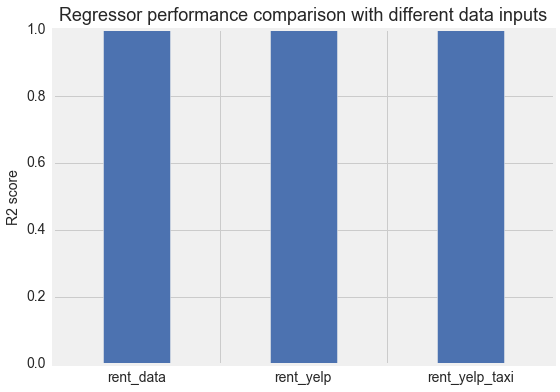

In [148]:
# Comparing regressor performances with different input data

x = [0,1,2]

y = [rent_reg_model.iloc[0, 2], rent_yelp_reg_model.iloc[0,2], 
     rent_yelp_taxi_reg_model.iloc[0,2]]
err = [rent_reg_model.iloc[0, 3], rent_yelp_reg_model.iloc[0,3], 
       rent_yelp_taxi_reg_model.iloc[0,3]]

fig, ax = plt.subplots(figsize = (8,6))

plt.bar(x, y, align = 'center', width=0.4, yerr = err)
plt.plot(x, y, 'xb--', linewidth = 2)

#ax.set_ylim(45, 55)
ax.set_xticklabels(['', 'rent_data', '', 
                    'rent_yelp', '', 'rent_yelp_taxi', ''])
ax.set_title('Regressor performance comparison with different data inputs', 
             y = 1.01, fontsize = 18)
ax.set_ylim(0,1)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylabel('R2 score', fontsize = 14)
plt.savefig('regressor_compare.png');

# Feature engineering

## Binning taxi dropoff data into 4 subsets

In [149]:
rand = 44

In [150]:
X = rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                    'Rate_mean', 'Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean', 'Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

X_taxibin = pd.concat([X, zip_dum], axis = 1)
y = rent_yelp_taxi['Price_per_sf_per_year']

# Create a independent train, test split and scaling to compare results
X_taxibin = X_taxibin.astype(float)

In [151]:
rent_yelp_taxibin_reg_model = custom_cross_val(X_taxibin, y, 10, 
                                               model_reg, scales, 13)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1063: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn

In [152]:
rent_yelp_taxibin_reg_model.head()

Model          Scaler   RMSE  Stdev
1       RandomForestRegressor    RobustScaler  47.35  31.23
0       RandomForestRegressor  StandardScaler  47.55  34.42
2       RandomForestRegressor    MinMaxScaler  47.86  35.77
17        KNeighborsRegressor    MinMaxScaler  48.14  32.66
10  GradientBoostingRegressor    RobustScaler  48.42  27.19

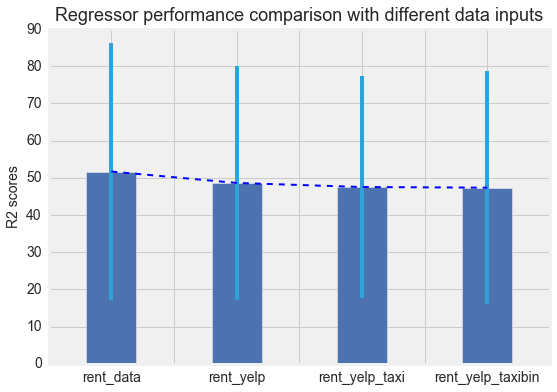

In [153]:
# Comparing regressor performances with different input data

x = [0,1,2, 3]

y = [rent_reg_model.iloc[0, 2], 
     rent_yelp_reg_model.iloc[0,2], 
     rent_yelp_taxi_reg_model.iloc[0,2], 
     rent_yelp_taxibin_reg_model.iloc[0,2]]

err = [rent_reg_model.iloc[0, 3], 
       rent_yelp_reg_model.iloc[0,3], 
       rent_yelp_taxi_reg_model.iloc[0,3], 
       rent_yelp_taxibin_reg_model.iloc[0,3]]

fig, ax = plt.subplots(figsize = (8,6))

plt.bar(x, y, align = 'center', width=0.4, yerr = err)
plt.plot(x, y, 'xb--', linewidth = 2)

#ax.set_ylim(45, 55)
ax.set_xticklabels(['', 'rent_data', 
                    '', 'rent_yelp', 
                    '', 'rent_yelp_taxi', 
                    '', 'rent_yelp_taxibin'])
ax.set_title('Regressor performance comparison with different data inputs', 
             y = 1.01, fontsize = 18)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylabel('R2 scores', fontsize = 14)
plt.savefig('regressors_compare_bin.png');

## Feature selection for continuous features using Recursive Feature Selection (RFE)

In [82]:
X = rent_yelp_taxi[['SF_avail', 'Cost_mean', 'Cost_std',
                    'Rate_mean', 'Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean', 'Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

y = rent_yelp_taxi['Price_per_sf_per_year']

# Create a independent train, test split and scaling to compare results
X = X.astype(float)

In [83]:
scale = StandardScaler()
model = GradientBoostingRegressor(random_state=rand, max_depth=2, 
                                  learning_rate=0.095, n_estimators=59)

selector = RFECV(model, step = 1, cv=10, n_jobs=-1)
selector.fit(X,y)

#best_pred = custom_pred(X_taxibin, y, model, scale, 13)

RFECV(cv=10,
   estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.095, loss='ls', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=59, presort='auto', random_state=44,
             subsample=1.0, verbose=0, warm_start=False),
   n_jobs=-1, scoring=None, step=1, verbose=0)

In [86]:
scale = StandardScaler()
model = GradientBoostingRegressor(random_state=rand, max_depth=2, 
                                  learning_rate=0.095, n_estimators=59)

selector = RFE(model, n_features_to_select=1, step = 1)
selector.fit(X,y)

#best_pred = custom_pred(X_taxibin, y, model, scale, 13)

RFE(estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.095, loss='ls', max_depth=2,
             max_features=None, max_leaf_nodes=None,
             min_impurity_split=1e-07, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=59, presort='auto', random_state=44,
             subsample=1.0, verbose=0, warm_start=False),
  n_features_to_select=1, step=1, verbose=0)

In [87]:
feature_importance = pd.DataFrame([X.columns, selector.ranking_])
feature_importance = feature_importance.T
feature_importance.columns = ['Feature', 'Rank']
feature_importance.sort_values('Rank', inplace = True)
feature_importance

Feature Rank
10  dropoff_hr_1200_1800    1
0               SF_avail    2
9   dropoff_hr_0600_1200    3
1              Cost_mean    4
11  dropoff_hr_1800_2359    5
5            Review_mean    6
12  dropoff_hr_2359_0600    7
6             Review_std    8
8          Sentiment_std    9
3              Rate_mean   10
7         Sentiment_mean   11
4               Rate_std   12
2               Cost_std   13

## Dropping low importance features

In [154]:
# Dropping "Cost_std", a measure of how varied the "$" ratings are for each of nearest 10 businesses on Yelp

X = rent_yelp_taxi[['SF_avail', 'Cost_mean', 
                    'Rate_mean','Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean','Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

# Concatenating with zipcode dummy columns
X_taxibin = pd.concat([X, zip_dum], axis = 1)
y = rent_yelp_taxi['Price_per_sf_per_year']

# Converting to float
X_taxibin = X_taxibin.astype(float)

In [155]:
ryt_drop_feat_reg_model = custom_cross_val(X_taxibin, y, 10, 
                                           model_reg, scales, 12)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:52: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:986: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/data.py:1063: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
//anaconda/lib/python2.7/site-packages/sklearn

In [156]:
ryt_drop_feat_reg_model.head()

Model          Scaler   RMSE  Stdev
1   RandomForestRegressor    RobustScaler  46.94  33.95
17    KNeighborsRegressor    MinMaxScaler   48.6  43.74
18                    SVR  StandardScaler  48.92  37.59
0   RandomForestRegressor  StandardScaler  49.34  40.48
5     ExtraTreesRegressor    MinMaxScaler  49.79  30.87

51.68
48.62
47.52
47.35
46.94


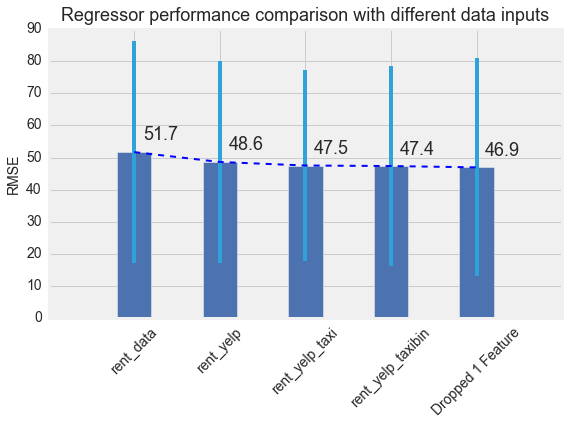

In [176]:
# Comparing regressor performances with different input data

x = [0,1,2, 3, 4]

y = [rent_reg_model.iloc[0, 2], 
     rent_yelp_reg_model.iloc[0,2], 
     rent_yelp_taxi_reg_model.iloc[0,2], 
     rent_yelp_taxibin_reg_model.iloc[0,2],
     ryt_drop_feat_reg_model.iloc[0,2]
    ]

err = [rent_reg_model.iloc[0, 3], 
       rent_yelp_reg_model.iloc[0,3], 
       rent_yelp_taxi_reg_model.iloc[0,3], 
       rent_yelp_taxibin_reg_model.iloc[0,3],
       ryt_drop_feat_reg_model.iloc[0,3]
      ]

fig, ax = plt.subplots(figsize = (8,6))

rect1 = plt.bar(x, y, align = 'center', width=0.4, yerr = err)
plt.plot(x, y, 'xb--', linewidth = 2)

def autolabel(rects):
    # attach some text labels
    for rect in rects:
        height = rect.get_height()
        print height
        ax.text(rect.get_x() + rect.get_width()/2. + 0.1, 1.05*height,
                str(round(height,1)),
                ha='left', va='bottom', fontsize = 18)
        
autolabel(rect1)

#ax.set_ylim(45, 55)
ax.set_xticklabels(['', 'rent_data', 
                    'rent_yelp', 
                    'rent_yelp_taxi', 
                    'rent_yelp_taxibin',
                    'Dropped 1 Feature'
                   ], rotation = 45)
ax.set_title('Regressor performance comparison with different data inputs', 
             y = 1.01, fontsize = 18)
ax.tick_params(axis = 'both', labelsize = 14)
ax.set_ylabel('RMSE', fontsize = 14)
plt.tight_layout()
plt.savefig('regressors_compare_bin.png');

### Comments:

"Cost_std", the standard deviation of "\$" rating on Yelp across neighboring business, a measure of how varied the types of business are within a location, was the lowest ranking continuous features. Removing it improved the performance of the model, increased R2 score from 0.49 to 0.52.

Standard deviation of R2 scores remained constant after removing lowest importance features. Further elimination of features resulted in deterioration of R2 scores. Hence only 1 feature was removed.

# Creating model as product for app

In [92]:
# Dropping "Cost_std", a measure of how varied the "$" ratings are for each of nearest 10 businesses on Yelp

X = rent_yelp_taxi[['SF_avail', 'Cost_mean', 
                    'Rate_mean','Rate_std', 'Review_mean', 
                    'Review_std', 'Sentiment_mean','Sentiment_std',
                    'dropoff_hr_0600_1200', 'dropoff_hr_1200_1800', 
                    'dropoff_hr_1800_2359', 'dropoff_hr_2359_0600']]

# Concatenating with zipcode dummy columns
X = pd.concat([X, zip_dum], axis = 1)
y = rent_yelp_taxi['Price_per_sf_per_year']

# Converting to float
X = X.astype(float)

In [93]:
model = RandomForestRegressor()
scale = StandardScaler()
no_cont_cols = 12

# Scaling appropriate columns
ss_x = scale.fit(X.iloc[:,:no_cont_cols])
ss_y = scale.fit(y.values.reshape(-1,1))

# Scaling data
X_scale = pd.DataFrame(ss_x.transform(X.iloc[:,:no_cont_cols]), columns = X.columns[:no_cont_cols])
y = ss_y.transform(y.values.reshape(-1,1))

# Combining with unscaled columns
X = pd.concat([X_scale, X.iloc[:,no_cont_cols:]], axis = 1)

# Fitting the model with training data
reg = model.fit(X, y.reshape(-1,1))

# Predicting X_test
#y_pred = model.predict(X_test)

#y_true_inv = ss_y.inverse_transform(y_test_scale)
#y_pred_inv = ss_y.inverse_transform(y_pred)


/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


In [94]:
with open('/Users/peidacai/Desktop/x_scaler.pkl', 'w') as f:
    pickle.dump(ss_x, f)

In [95]:
with open('/Users/peidacai/Desktop/y_scaler.pkl', 'w') as f:
    pickle.dump(ss_y, f)

In [96]:
with open('/Users/peidacai/Desktop/model.pkl', 'w') as f:
    pickle.dump(reg, f)

# Stakeholder Recommendations

Suggestions for future work can be categorized into its three data sources:

1. Rental data

    - Only units that were listed in November 2016 was used to create the model. Historical data from July 2015 to June 2016 should be used since this coincides with the taxi data source.

    - Prices of nearby rental locations can also be used as a feature.

2. Taxi data

    - Yellow cab data has a location bias to Manhattan. Data from green taxi and Uber could be used to complement the yellow cab data to provide a more holistic view of passenger distribution across New York City.

3. Social Media data

    - Yelp review data could be normalize by time, restricted to reviews from July 2015 to June 2016, to offer a more time sensitive representation of popularity across customers.

    - Yelp data, in itself, could also have selection bias, such as user types (only certain types of customers review on Yelp) or bias from Yelp (displaying businesses which paid for its services). Weightage of Yelp reviews can be reduced by introducing other social media data such as Google reviews.

# Validation of model over time

The input data to this model was obtained at a fixed point in time, especially rental data. To validate the model, the following methods are suggested:

1. Use historical rental prices

2. Use new rental data as listings become available

# Deploying model in production environment

To use the model in production environment, the following three ways are suggested:

1. Operate directly using Jupyter notebook

    - Cheapest implementation cost
    - Ideal for single user
    - Not user-friendly for non-technical users
    - Not scalable

2. Create a flask app on local server

    - Low cost implementation
    - Ideal for internal company usage without access from internet
    - Complexity of Graphic User Interface (GUI) can be customized to client's requirement
    - No 24/7 access
    - Single point of failure
    
3. Create a flask app on AWS

    - Highest cost implementation
    - Ideal for implementation onto websites
    - Customization GUI
    - 24/7 access
    - Built-in redundancies by host (AWS)

In [97]:
# Reference dataframe with taxi information indexed by zipcodes
with open('/Users/peidacai/GA-DSI/projects/projects-capstone/part-05/assets/taxi_ref_df.pkl', 'r') as f:
    taxi_ref_df = pickle.load(f)

# Reference dataframe with yelp review information indexed by zipcodes
with open('/Users/peidacai/GA-DSI/projects/projects-capstone/part-05/assets/full_yelp_ref_df.pkl', 'r') as f:
    yelp_ref_df = pickle.load(f)

# Prediction RandomForest regressor ML model
with open('/Users/peidacai/GA-DSI/projects/projects-capstone/part-05/assets/model.pkl', 'r') as f:
    model = pickle.load(f)

# StandardScaler fitted to training X data, used to transform continuous data of x
with open('/Users/peidacai/GA-DSI/projects/projects-capstone/part-05/assets/x_scaler.pkl', 'r') as f:
    ss_x = pickle.load(f)

# StandardScaler fitted to training y data, used to inverse transform predict y
with open('/Users/peidacai/GA-DSI/projects/projects-capstone/part-05/assets/y_scaler.pkl', 'r') as f:
    ss_y = pickle.load(f)

# Empty X input dataframe for zipcodes
with open('/Users/peidacai/GA-DSI/projects/projects-capstone/part-05/assets/x_zip.pkl', 'r') as f:
    x_zip = pickle.load(f)

# Function to populate respective cell in zipcode dataframe
def set_zip(zipcode, zip_df):
    if zipcode == '10001':
        return zip_df
    else:
        try:
            for i in zip_df.columns:
                new_i = i.replace('Zip__', '')
                if new_i == zipcode:
                    zip_df.loc[0, i] = 1
                    return zip_df
                else:
                    return zip_df
        except:
            return zip_df

In [108]:
zipcode = 10010
area = 20000

In [109]:
# Get the respective row on taxi df based on zipcode
taxi = taxi_ref_df.loc[zipcode, ['dropoff_hr_0600_1200', 
                            'dropoff_hr_1200_1800', 
                            'dropoff_hr_1800_2359', 
                            'dropoff_hr_2359_0600']]

# Create floor area into a pandas series
floor_area = pd.Series([area], index = ['SF_avail'])

# Get the respective row on yelp df based on zipcode
yelp = yelp_ref_df.loc[zipcode, :]



In [110]:
comb = pd.DataFrame(pd.concat([floor_area, yelp, taxi], axis = 0))
comb = comb.T

scale_comb = pd.DataFrame(ss_x.transform(comb), columns = comb.columns)
inp_x = pd.concat([scale_comb, set_zip(str(zipcode), x_zip)], axis = 1)

y_pred = round(ss_y.inverse_transform(model.predict(inp_x))[0],2)
print y_pred

78.82
